In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter


In [22]:
df = pd.read_csv("Year Order Item Data.csv", parse_dates=['date'])

In [23]:
numeric_cols = ['my_amount', 'total_tax', 'discount', 'delivery_charge', 'container_charge',
                'service_charge', 'additional_charge', 'waived_off', 'round_off',
                'total', 'item_price', 'item_quantity', 'item_total']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=['invoice_no', 'item_name', 'item_quantity', 'item_total'], inplace=True)

# Basic net sale calculation
df['net_sales'] = df['item_total'] - df[['discount', 'waived_off']].sum(axis=1)
df['date'] = pd.to_datetime(df['date'])

In [24]:
# adding some time columns
df['YearMonth'] = df['date'].dt.to_period('M')
df['DateOnly'] = df['date'].dt.date
df['Weekday'] = df['date'].dt.day_name()
df['Hour'] = df['date'].dt.hour

### Invoice Level KPI's

In [25]:
invoice_kpis = (
    df.groupby('invoice_no').agg(
        order_date=('date', 'min'),
        customer_phone=('customer_phone', 'first'),
        customer_name=('customer_name', 'first'),
        total_items=('item_name', 'nunique'),
        total_quantity=('item_quantity', 'sum'),
        total_discount=('discount', 'sum'),
        total_waived_off=('waived_off', 'sum'),
        net_invoice_value=('net_sales', 'sum')
    ).reset_index()
)

invoice_kpis['order_day'] = invoice_kpis['order_date'].dt.day_name()
invoice_kpis['order_date_only'] = invoice_kpis['order_date'].dt.date


In [ ]:
invoice_kpis.to_csv("../results/order_analysis/Invoice_Aggregation.csv", index=False)

### Product Co-occurence Matrix

In [27]:
invoice_items = df.groupby('invoice_no')['item_name'].apply(list).reset_index()

In [28]:
invoice_items

,invoice_no,item_name
0,1,"[Strawberry Shake (Milkshake), Chocolate Shake..."
1,2,[Classic Lemonade]
2,3,[Waffles]
3,4,"[Banana Shake (Milkshake), Chocolate Shake (Mi..."
4,5,"[Wonder Vanilla Shake (Milkshake), Chocolate S..."
...,...,...
11362,11363,[Pineapple]
11363,11364,"[Chocolate Strawberry Shake (Milkshake), Caram..."
11364,11365,[Kulfi Nuts Shake (Milkshake)]
11365,11366,[Strawberry Shake (Milkshake)]


In [ ]:
pair_counter = Counter()


for items in invoice_items['item_name']:
    unique_items = list(set(items))
    if len(unique_items) > 1:
        pairs = combinations(sorted(unique_items), 2)
        pair_counter.update(pairs)

In [30]:
co_occurrence_df = pd.DataFrame(pair_counter.items(), columns=['item_pair', 'count'])
co_occurrence_df[['item_1', 'item_2']] = pd.DataFrame(co_occurrence_df['item_pair'].tolist(), index=co_occurrence_df.index)
co_occurrence_df.drop(columns='item_pair', inplace=True)
co_occurrence_df.sort_values(by='count', ascending=False, inplace=True)


In [ ]:
pivot_df = co_occurrence_df.pivot(index='item_1', columns='item_2', values='count').fillna(0)

pivot_df.to_csv("../results/order_analysis/Product_Co_occurence_Matrix.csv", index=False)

pivot_df

item_2,Belgium Dark Chocolate Brownie Shake (Milkshake),Belgium Dark Chocolate Brownie Shake (Thickshake),Belgium Dark Chocolate Shake (Milkshake),Belgium Dark Chocolate Shake (Thickshake),Berryblast,Blackcurrant Crunch Shake (Milkshake),Blackcurrant Shake (Milkshake),Blackcurrant Shake (Thickshake),Blackcurrent Shake (Milkshake),Blue Curacao,...,Strawberry Crunch Shake (Thickshake),Strawberry Lemonade,Strawberry Shake (Milkshake),Strawberry Shake (Thickshake),Waffle,Waffle Special Offer,Waffles,Watermelon,Wonder Vanilla Shake (Milkshake),Wonder Vanilla Shake (Thickshake)
item_1,,,,,,,,,,,,,,,,,,,,,
5 Star Shake (Milkshake),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5 Star Shake (Thickshake),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anjir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Banana Crunch (Thickshake),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Banana Crunch Shake (Milkshake),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Strawberry Shake (Thickshake),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,3.0,1.0
Waffle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0,0.0
Waffle Special Offer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0


In [39]:
# Rebuild full symmetric matrix for heatmap (upper + lower triangle)
matrix_df = pd.pivot_table(
    co_occurrence_df,
    values='count',
    index='item_1',
    columns='item_2',
    fill_value=0
)

# Fill lower triangle to make it fully symmetric
full_matrix = matrix_df + matrix_df.T.fillna(0)


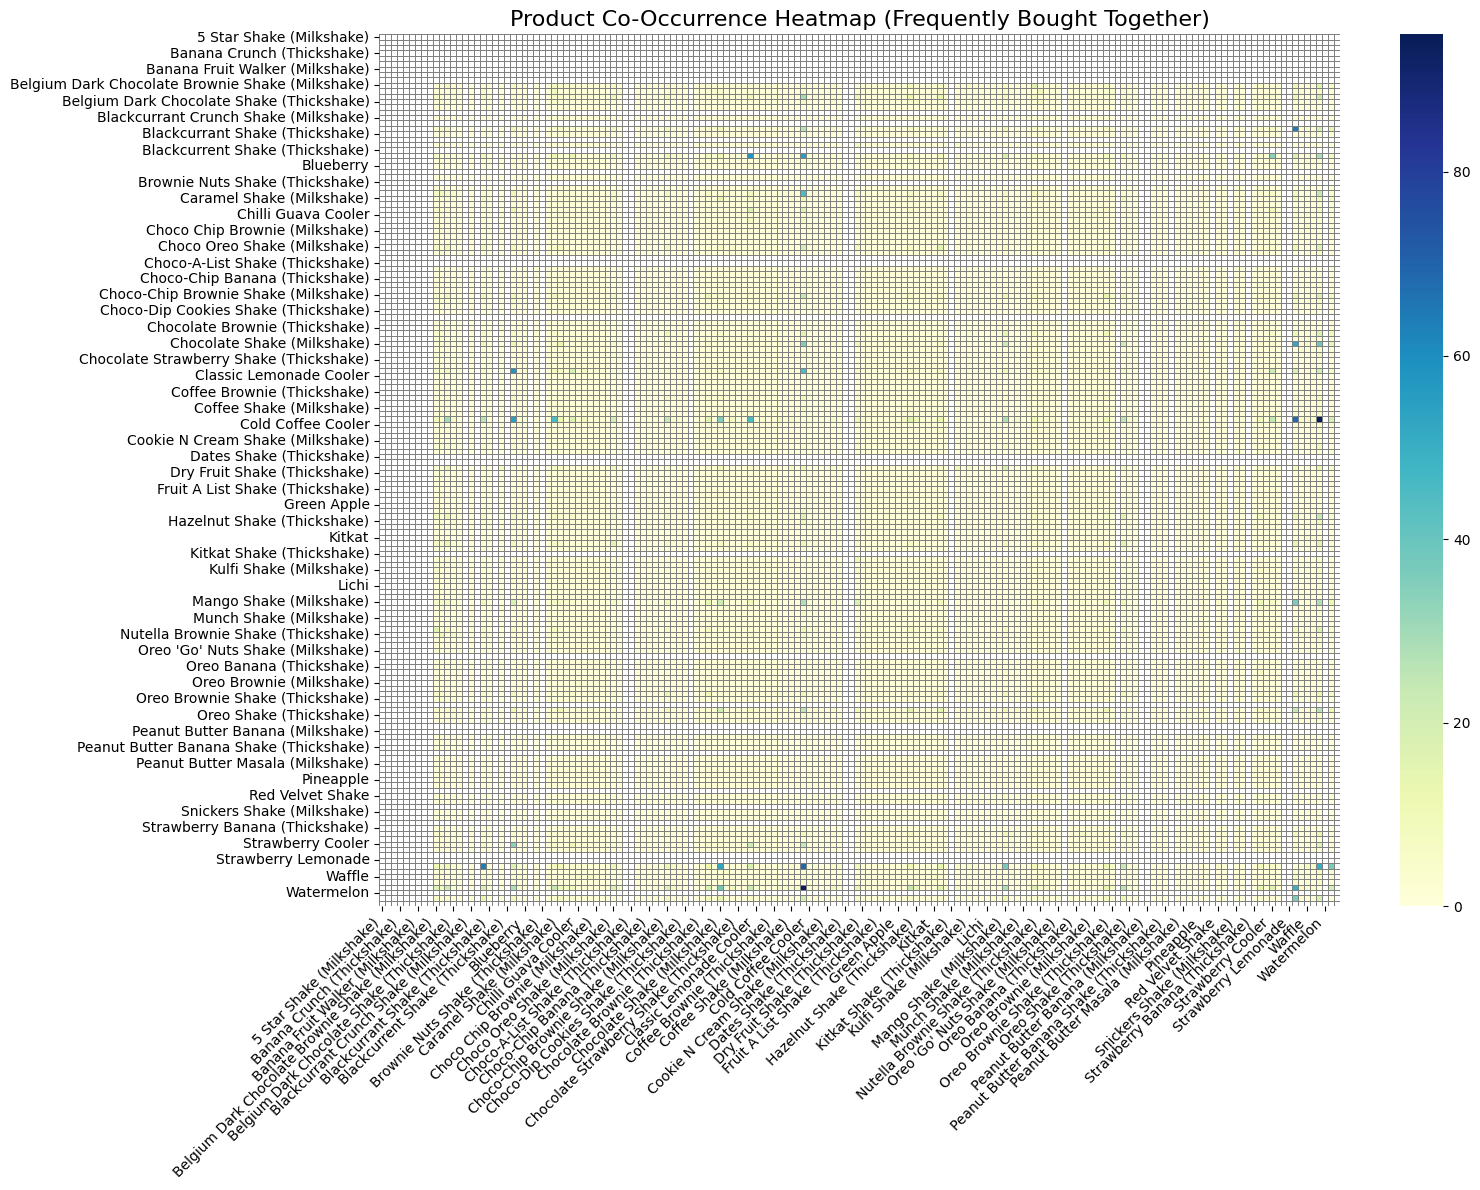

In [40]:
plt.figure(figsize=(16, 12))
sns.heatmap(full_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='gray')

plt.title("Product Co-Occurrence Heatmap (Frequently Bought Together)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
top_items = co_occurrence_df['item_1'].value_counts().head(30).index
filtered_matrix = full_matrix.loc[top_items, top_items]

filtered_matrix.to_csv("../results/order_analysis/Product_Co_occurence_Matrix_filtered.csv", index=False)

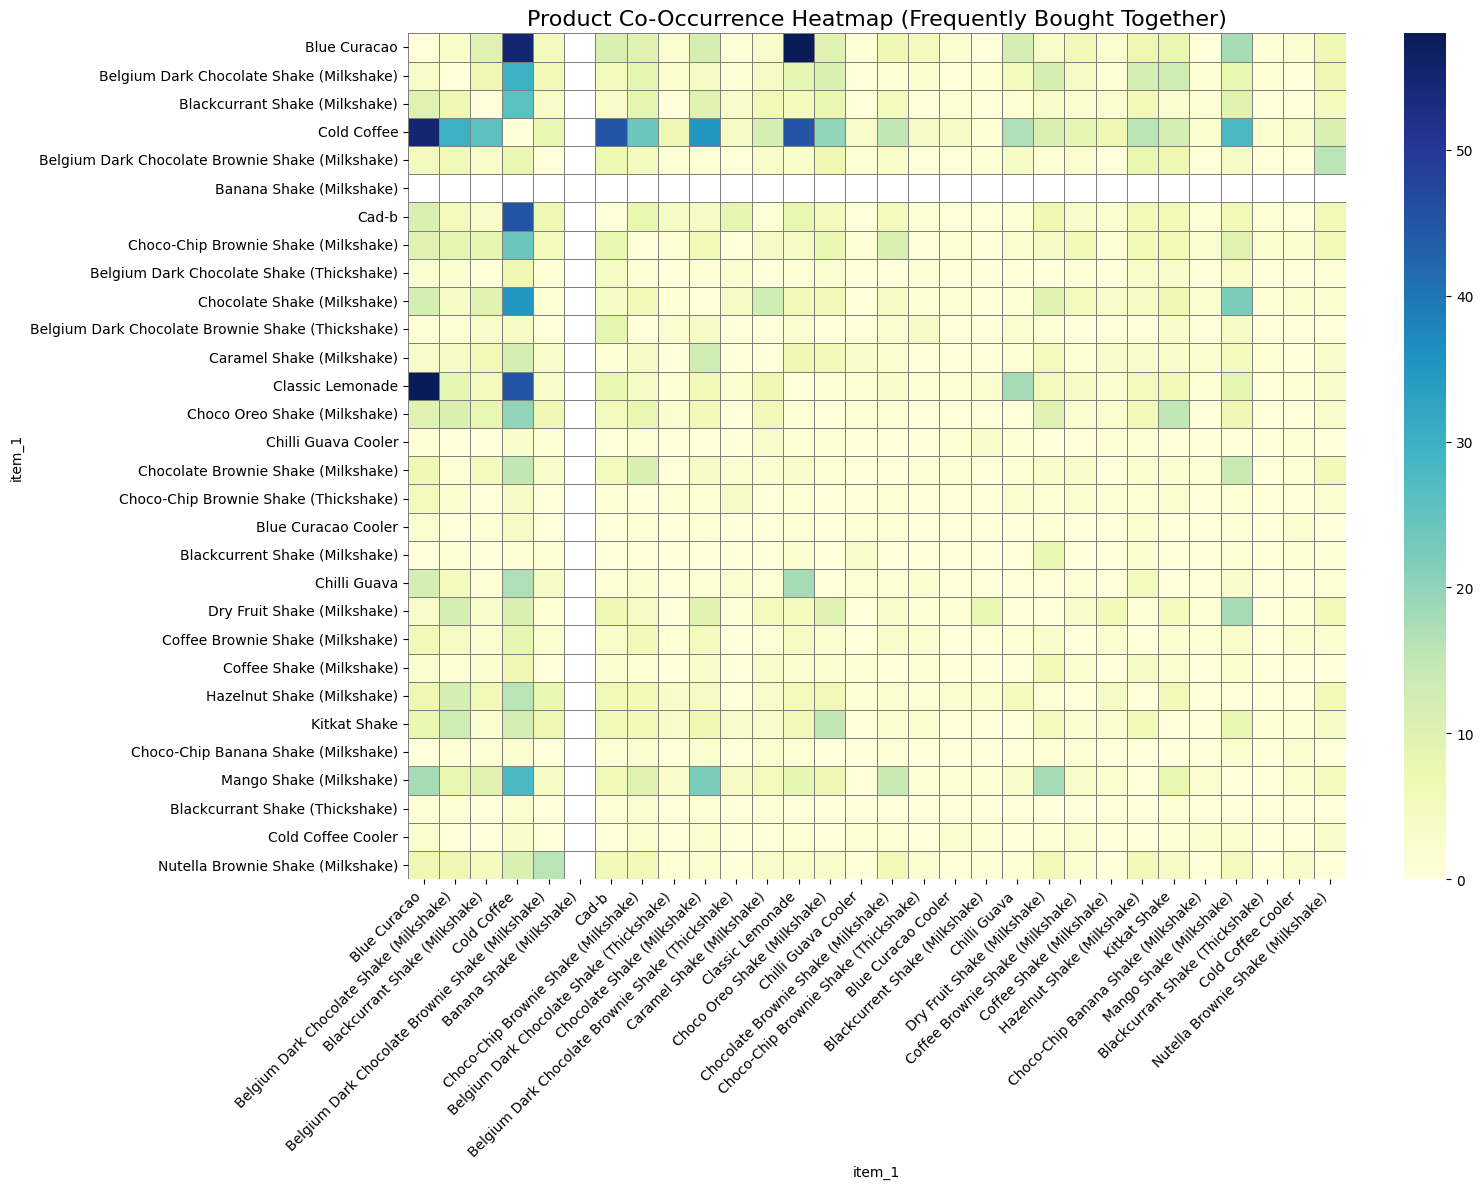

In [45]:
plt.figure(figsize=(16, 12))
sns.heatmap(filtered_matrix, cmap='YlGnBu', linewidths=0.5, linecolor='gray')

plt.title("Product Co-Occurrence Heatmap (Frequently Bought Together)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
